In [1]:
!git clone https://github.com/JurjiuDarius/Segmentation-of-Teeth-in-Panoramic-X-ray-Image.git

Cloning into 'Segmentation-of-Teeth-in-Panoramic-X-ray-Image'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 211 (delta 7), reused 0 (delta 0), pack-reused 196
Receiving objects: 100% (211/211), 22.60 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#take a look at the kind of GPU we have
!nvidia-smi

Sat Jan 13 07:09:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import sys
sys.path.append("/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net")

In [5]:
%cd /content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image
#!pip install -qr requirements.txt
#You can  use pip install however colab includes all libraries so we dont need them

/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image


In [12]:
%mkdir /content/Data
%cp /content/drive/MyDrive/DentalPanoramicXrays.zip /content/Data

In [14]:
from process_zip import process_zip
import os
path = "/content/Data"
process_zip(path)

In [15]:
from images_prepare import *
#pre_images(resize_shape,path,include_zip)
X,X_sizes=pre_images((512,512),path,True)

In [16]:
from masks_prepare import *
#Y=pre_masks(resize_shape=(512,512),path='/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/Original_Masks')  ORIGINALL MASKS function
Y=pre_splitted_masks(path='/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/Custom_Masks') #Custom Splitted MASKS size 512x512


In [17]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [18]:
x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

In [19]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-7zqmds1x
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-7zqmds1x
  Resolved https://github.com/albu/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


In [20]:
!yes | pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.9.0.80
Uninstalling opencv-python-headless-4.9.0.80:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless-4.9.0.80.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libavcodec-512f0acb.so.59.37.100
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libavformat-3ff1be5b.so.59.27.100
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libavutil-a0a0531e.so.57.28.100
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libcrypto-0c9efecc.so.1.1
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libpng16-7379b3c3.so.16.40.0
    /usr/local/lib/p

In [21]:
!yes | pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 32.9 MB/s eta 0:00:00


In [22]:
import cv2

import albumentations as A
#Augmention . Change what you want ! Care about Your GPU and CPU RAM

#If you get error : cannot import name '_registerMatType' from 'cv2.cv2' :
#!pip uninstall opencv-python-headless==4.5.5.62
#!pip install opencv-python-headless==4.5.2.52

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=512, height=512),
                 A.PadIfNeeded(min_height=512, min_width=512, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                            A.Resize(512, 512, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<4):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [23]:
#For Relase unneccasery memory
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

In [24]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)
print(random_number)

65


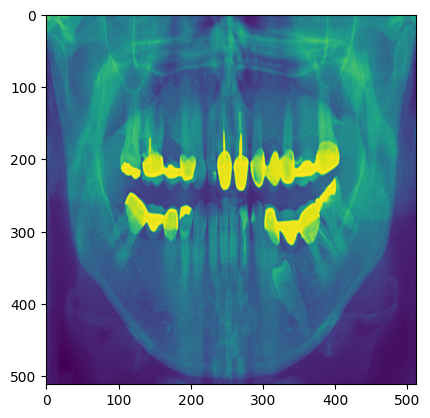

In [25]:
#Checking data X  and Y matching
plt.imshow(x_train[random_number,:,:,0])

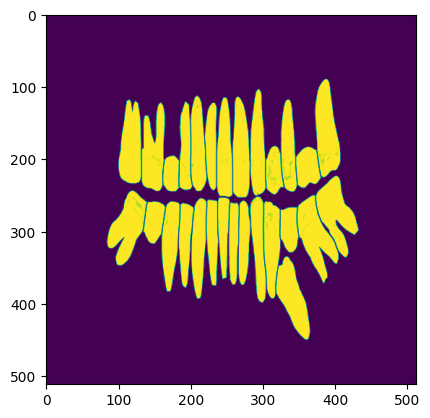

In [26]:
#Checking data X  and Y matching
plt.imshow(y_train[random_number,:,:,0])

In [27]:
from model import *
model=UNET(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['dropout[0][0]']             
                                                                                              

In [28]:
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Your choice batch and epoch
model.fit(x_train,y_train,batch_size=8,epochs=150,verbose=1)

Epoch 1/150
66/66 [==============================] - 89s 502ms/step - loss: 0.3873 - accuracy: 0.7775
Epoch 2/150
66/66 [==============================] - 9s 134ms/step - loss: 0.2354 - accuracy: 0.8519
Epoch 3/150
66/66 [==============================] - 9s 134ms/step - loss: 0.2024 - accuracy: 0.8640
Epoch 4/150
66/66 [==============================] - 9s 134ms/step - loss: 0.1846 - accuracy: 0.8703
Epoch 5/150
66/66 [==============================] - 9s 134ms/step - loss: 0.1760 - accuracy: 0.8752
Epoch 6/150
66/66 [==============================] - 9s 134ms/step - loss: 0.1649 - accuracy: 0.8797
Epoch 7/150
66/66 [==============================] - 9s 134ms/step - loss: 0.1556 - accuracy: 0.8834
Epoch 8/150
66/66 [==============================] - 9s 134ms/step - loss: 0.1523 - accuracy: 0.8849
Epoch 9/150
66/66 [==============================] - 9s 134ms/step - loss: 0.1507 - accuracy: 0.8865
Epoch 10/150
66/66 [==============================] - 9s 134ms/step - loss: 0.1416 - accur

In [29]:
predict_img=model.predict(x_test)
##model.save(path)
predict=predict_img[1,:,:,0]

1/1 [==============================] - 6s 6s/step


In [30]:
#Example Test
from sklearn.metrics import f1_score
import numpy as np
predict_img1=(predict_img>0.25)*1
y_test1=(y_test>0.25)*1

f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9567174044522372

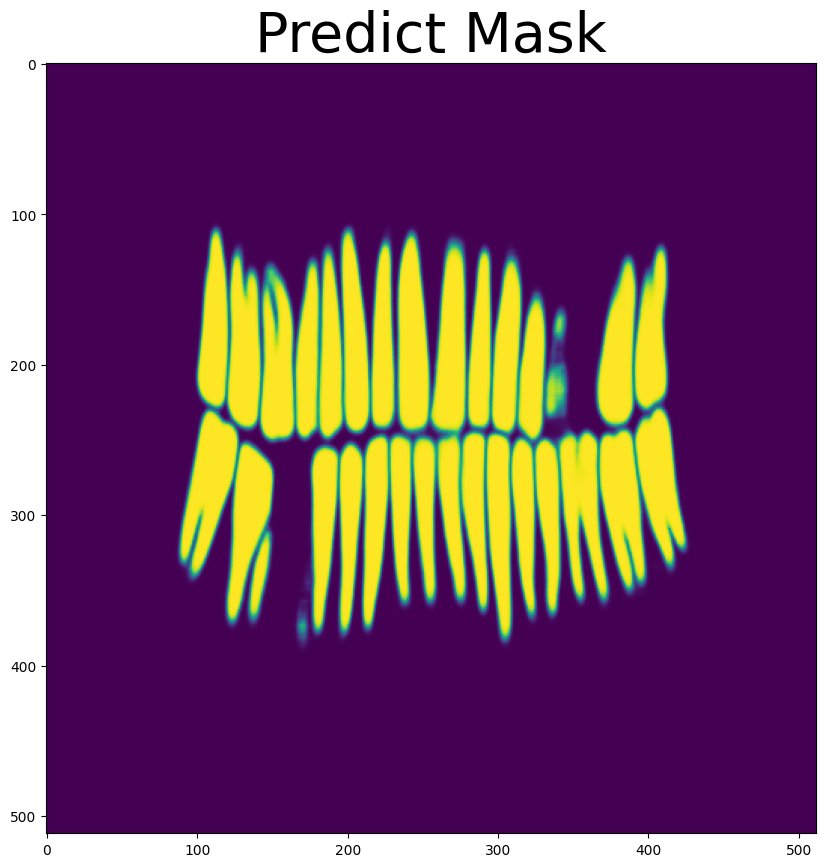

In [31]:

plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
#For CCA, we saved
plt.imsave("/content/predict.png",predict)

In [32]:
from google.colab.patches import cv2_imshow
import cv2
from CCA_Analysis import *


##Plotting - RESULT Example
img=cv2.imread("/content/Data/Images/107.png")#original img 107.png

predict1 = cv2.resize(predict, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

mask=np.uint8(predict1*255)#
_, mask = cv2.threshold(mask, thresh=255/2, maxval=255, type=cv2.THRESH_BINARY)
cnts,hieararch=cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(img[:,:,0], cnts, -1, (255, 0, 0) , 2)
img = cv2.UMat.get(img)
cv2_imshow(img)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - Layout of the output array image is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'image'


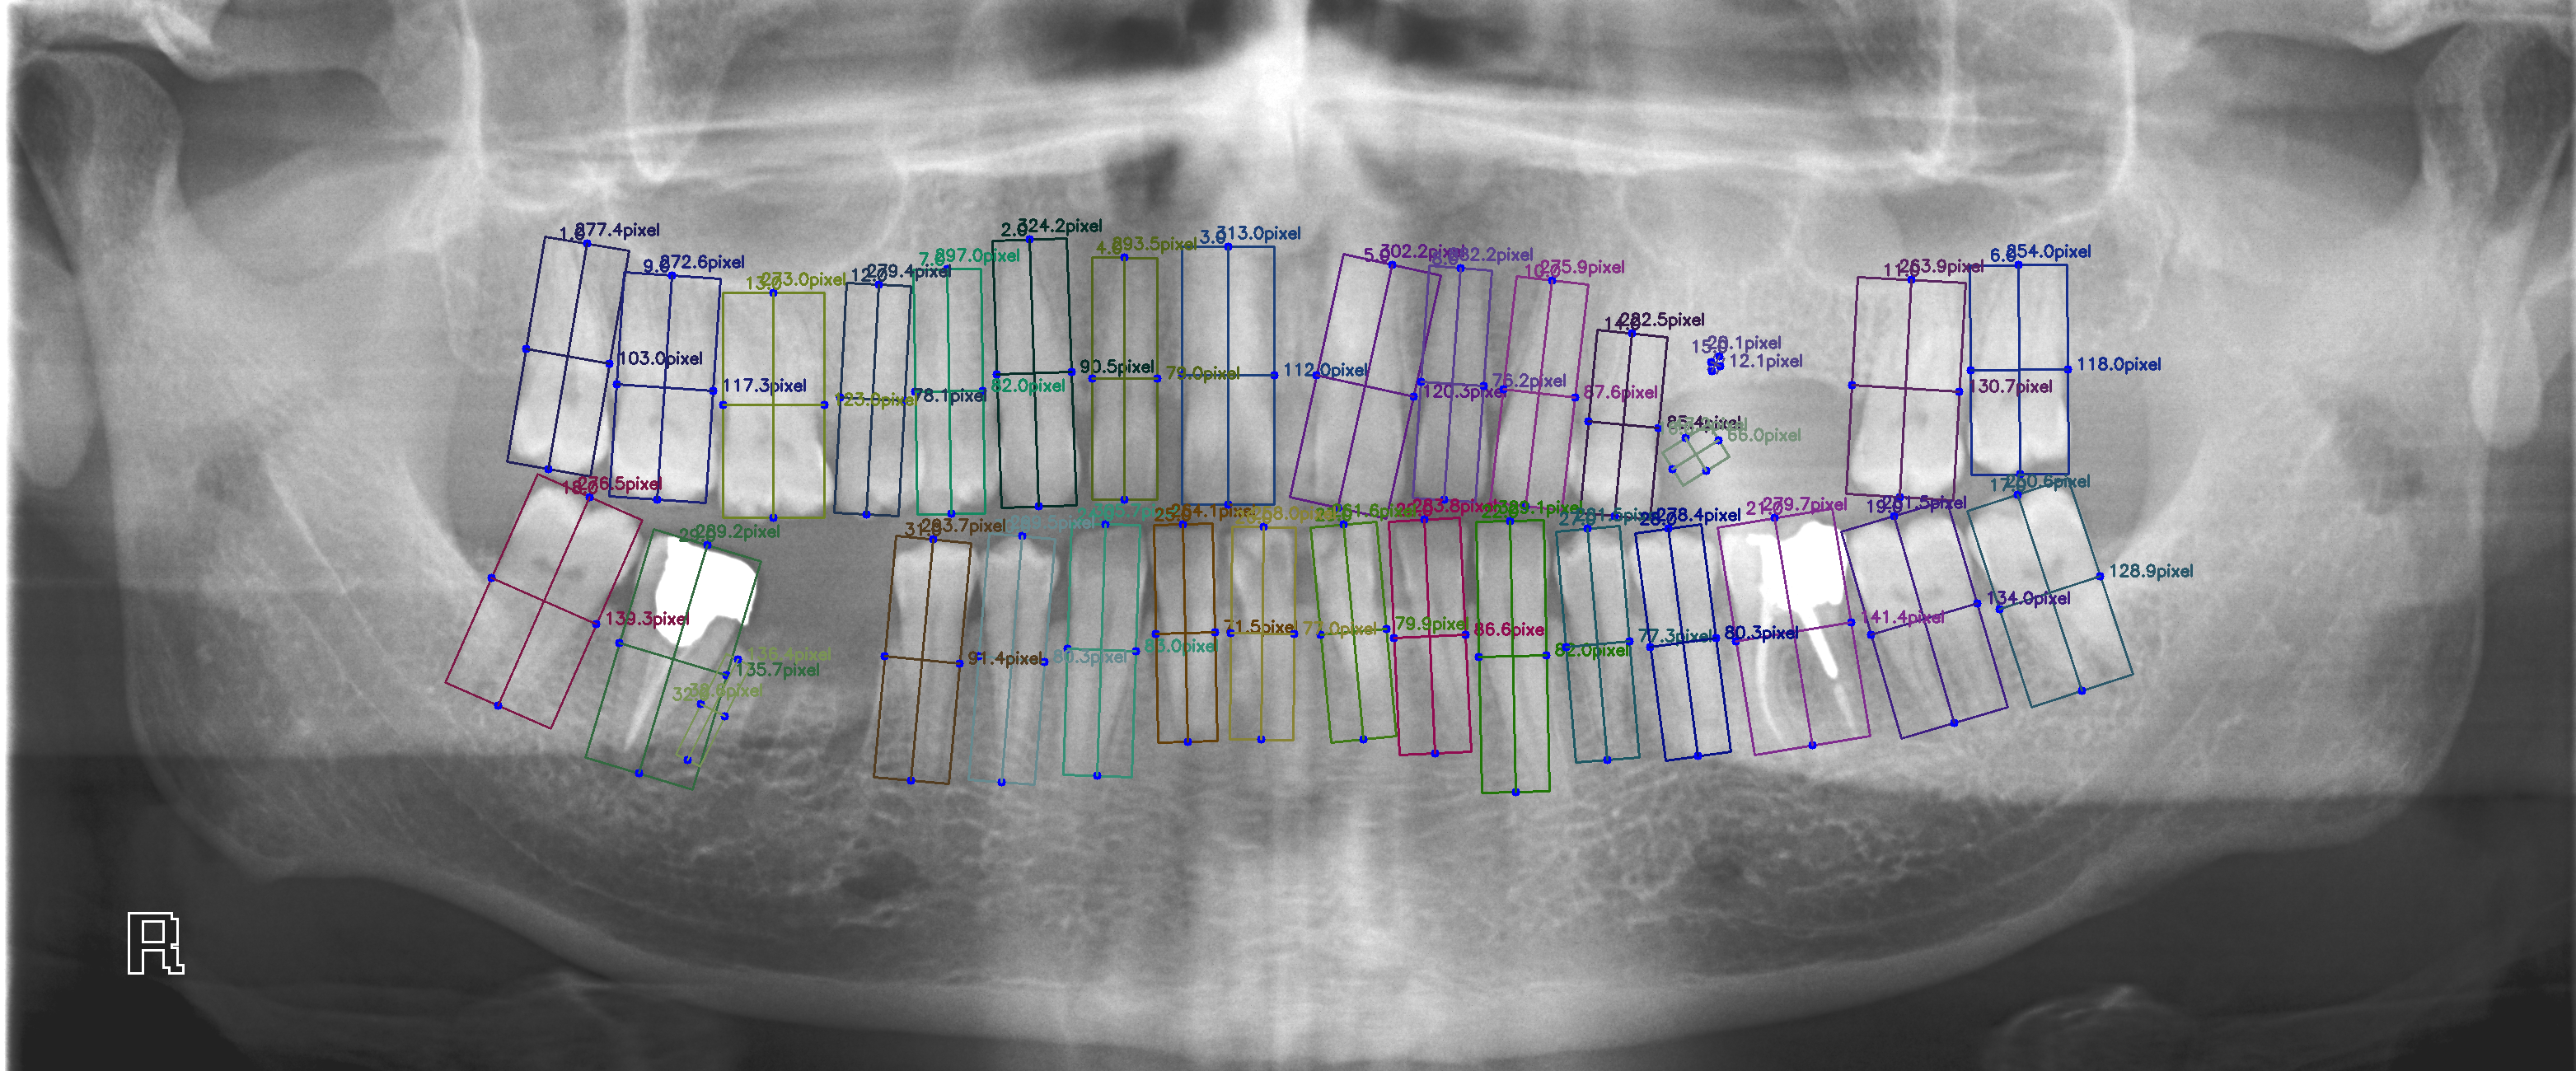

In [33]:
from google.colab.patches import cv2_imshow
import cv2
from CCA_Analysis import *


##Plotting - RESULT Example with CCA_Analysis
img=cv2.imread("/content/Data/Images/107.png")#original img 107.png

#load image (mask was saved by matplotlib.pyplot)
predicted=cv2.imread("/content/predict.png")

predicted = cv2.resize(predicted, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

cca_result,teeth_count=CCA_Analysis(img,predicted,3,2)
cv2_imshow(cca_result)

In [34]:
print(teeth_count,"Teeth Count")

30 Teeth Count


In [36]:
import tensorflow as tf
tf.keras.models.save_model(model, '/content/drive/MyDrive/dental_xray_seg.keras')

In [39]:
from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/dental_xray_seg.keras')

In [41]:
predict_img_2=loaded_model.predict(x_test)
##model.save(path)
predict=predict_img[2,:,:,0]

1/1 [==============================] - 0s 29ms/step


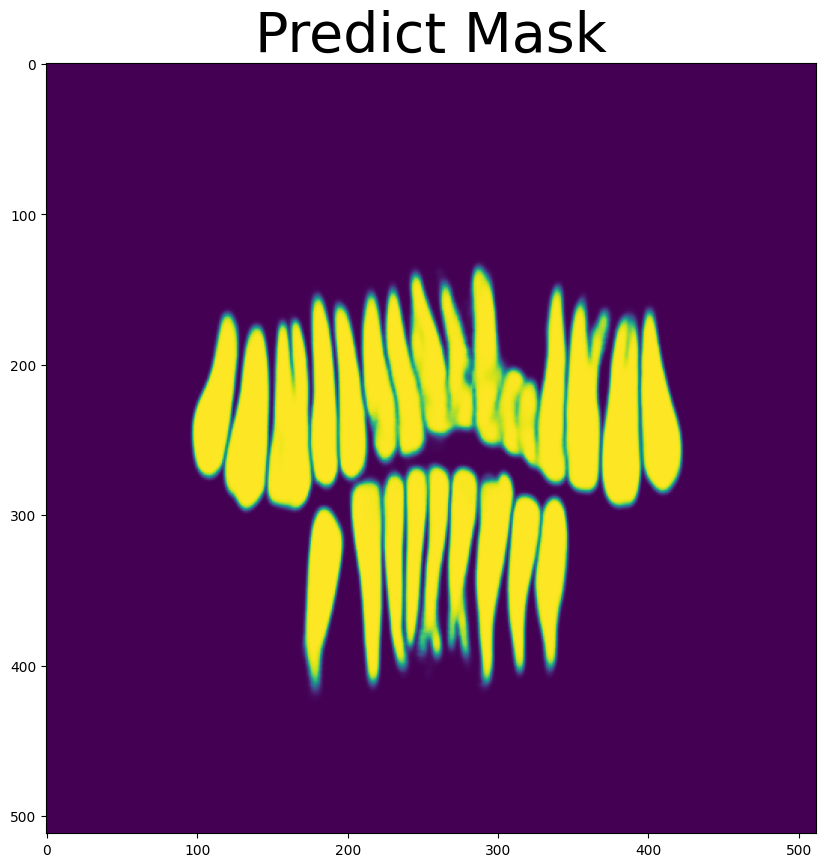

In [43]:
plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
plt.imsave("/content/predict2.png",predict)

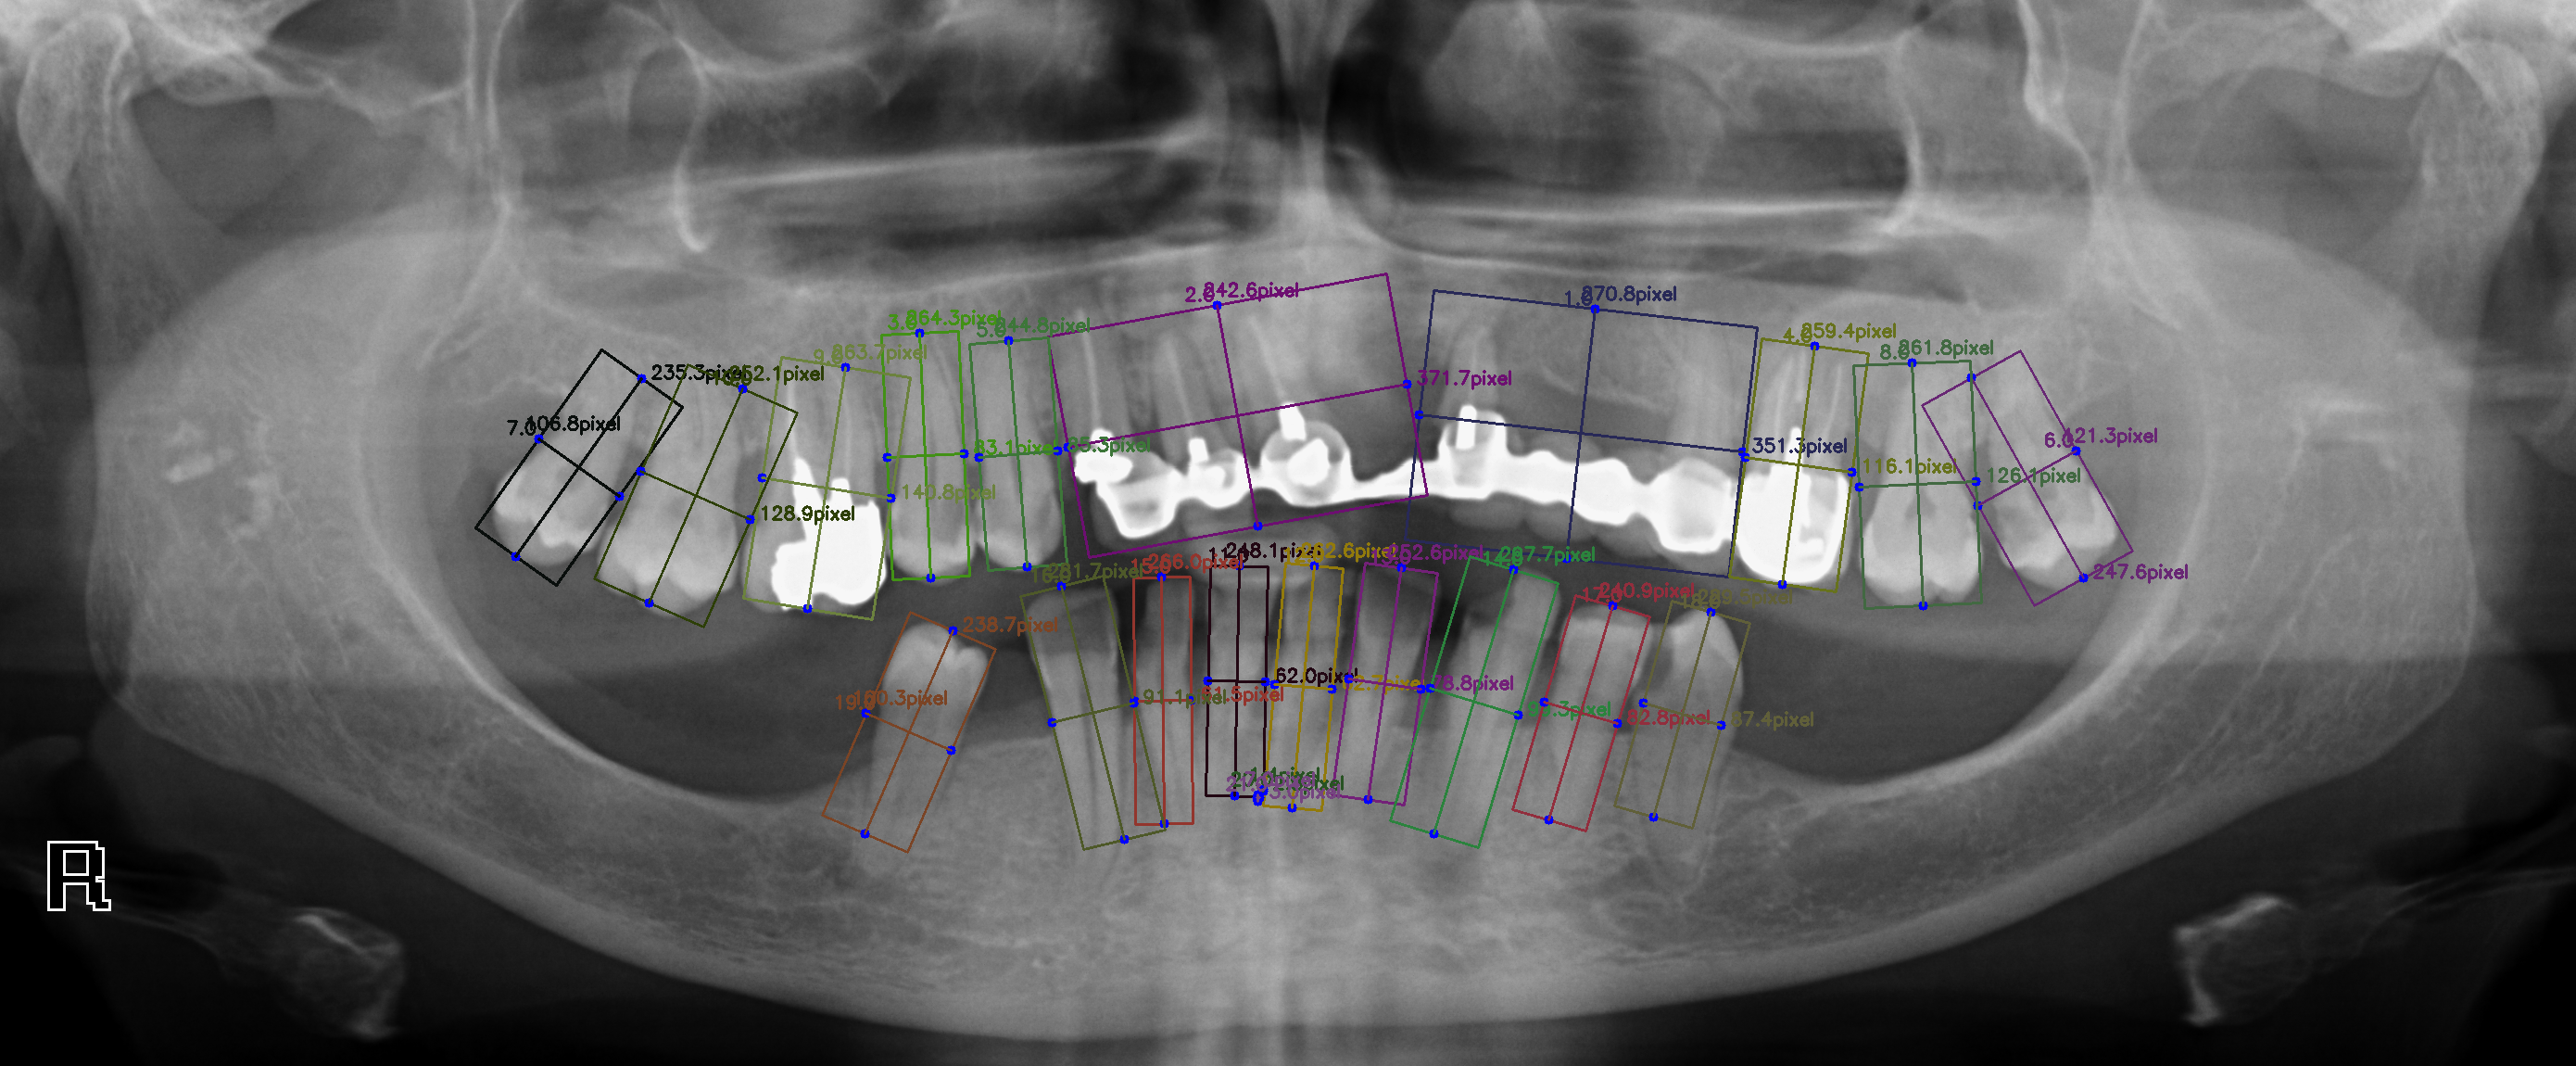

In [45]:
from google.colab.patches import cv2_imshow
import cv2
from CCA_Analysis import *


##Plotting - RESULT Example with CCA_Analysis
img=cv2.imread("/content/Data/Images/108.png")#original img 107.png

#load image (mask was saved by matplotlib.pyplot)
predicted=cv2.imread("/content/predict2.png")

predicted = cv2.resize(predicted, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

cca_result,teeth_count=CCA_Analysis(img,predicted,3,2)
cv2_imshow(cca_result)
